In [27]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
#Import needed libraries for deep learning such as tensorflow
# keras, matplotlib for plotting graphs or images
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
#Define Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [3]:
# Using tf dataset to utilize batches
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Desktop/DLLCP/lung_image_sets",
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15000 files belonging to 3 classes.


2025-02-14 16:29:11.010021: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-14 16:29:11.010191: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-14 16:29:11.010203: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1739521751.010512  336521 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739521751.010684  336521 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#see the class names in the tf data set 3 classes
class_names = dataset.class_names
class_names

['lung_aca', 'lung_n', 'lung_scc']

In [5]:
#check the values in dataset, it includes baches, images and rgb channel
# 1 bach 32 images belonging to 3 classes
for image_batch, cli_batch in dataset.take(1):
    print(image_batch.shape)
    print(cli_batch.numpy())

(32, 224, 224, 3)
[0 1 2 0 0 0 0 1 1 1 0 2 1 0 2 2 2 0 2 2 1 1 1 0 2 0 2 1 0 0 1 1]


2025-02-14 16:29:18.026237: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-02-14 16:29:18.469975: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


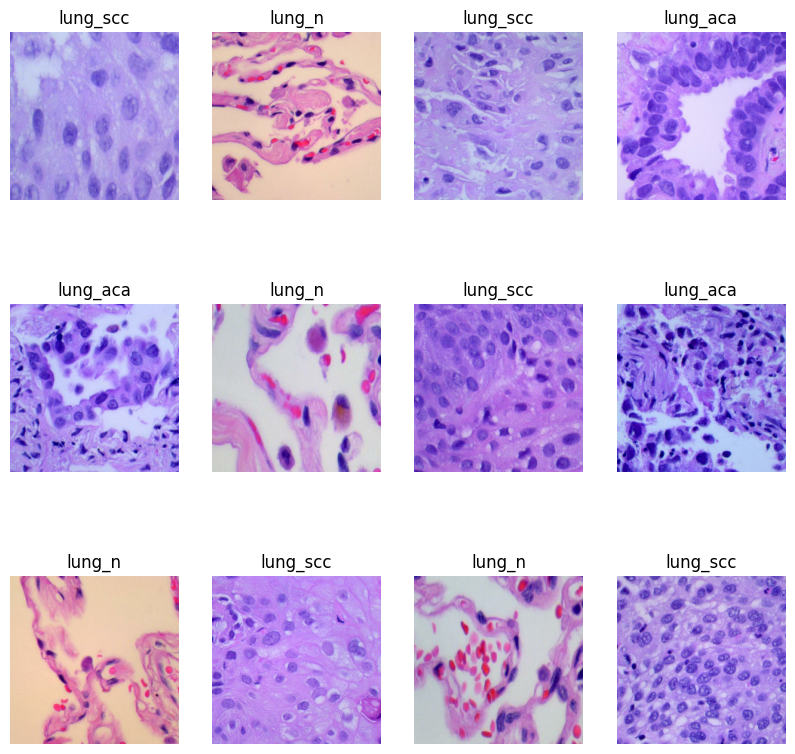

In [6]:
# plotting the 12 images in first random batch
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# 32 batches of each 469 images giving 15008
len(dataset)

469

In [8]:
469*32

15008

In [9]:
# splitting into train, validation and test splits

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [11]:
len(train_ds)


375

In [12]:
len(val_ds)


46

In [13]:
len(test_ds)


48

In [14]:
type(train_ds)


tensorflow.python.data.ops.take_op._TakeDataset

In [15]:
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
from tensorflow.keras.layers import RandomZoom, RandomFlip, RandomRotation, Resizing, Rescaling 


In [17]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),  # Resize to 224x224 (or 256x256)
    layers.Rescaling(1./255)    # Normalize pixel values to [0, 1]
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

#pretrained_model_without_top_layer = hub.KerasLayer(
 #   feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
IMAGE_SIZES = [224, 224]
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
mn = VGG19(input_shape= IMAGE_SIZES + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in mn.layers:
  layer.trainable = False

x = Flatten()(mn.output)

prediction = Dense(3, activation='softmax')(x)
# Load the pretrained model (MobileNetV2) without the top classification layer
model = Model(inputs=mn.input, outputs=prediction)

# Freeze the layers of the base model
#base_model.trainable = False



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [31]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │        75,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099,651 (76.67 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 226s 593ms/step - accuracy: 0.8778 - loss: 2.3975 - val_accuracy: 0.9470 - val_loss: 0.9392
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 224s 597ms/step - accuracy: 0.9539 - loss: 0.9279 - val_accuracy: 0.9572 - val_loss: 1.0246
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 247s 658ms/step - accuracy: 0.9706 - loss: 0.6726 - val_accuracy: 0.9681 - val_loss: 1.0736
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 250s 666ms/step - accuracy: 0.9705 - loss: 0.7239 - val_accuracy: 0.9538 - val_loss: 2.1654
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 270s 719ms/step - accuracy: 0.9761 - loss: 0.6142 - val_accuracy: 0.9524 - val_loss: 2.3546
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 302s 805ms/step - accuracy: 0.9797 - loss: 0.4781 - val_accuracy: 0.9538 - val_loss: 2.2194
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 289s 770ms/step - accuracy: 0.9834 - loss: 0.4104 - val_accuracy: 0.9660 - val_loss: 1.4179
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 277s 738ms/step - accuracy: 0.9899 -

In [34]:
scores = model.evaluate(test_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 495ms/step - accuracy: 0.9540 - loss: 2.9594


In [35]:
scores

[3.3093769550323486, 0.9515706896781921]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 375}

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
type(history.history['loss'])

list

In [40]:
len(history.history['loss'])

10

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.6791037321090698,
 0.911687433719635,
 0.6559939980506897,
 0.844903826713562,
 0.5569956302642822]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

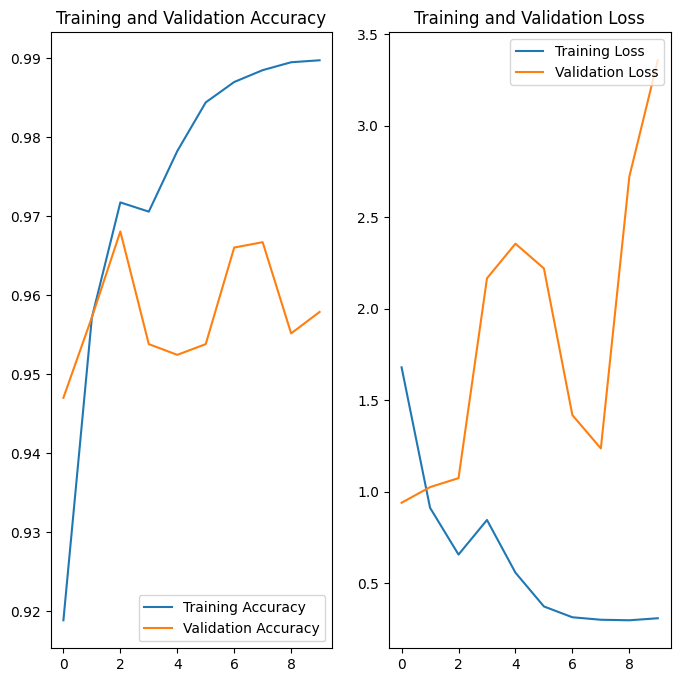

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: lung_n
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
predicted label: lung_n


2025-02-14 19:40:26.125345: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


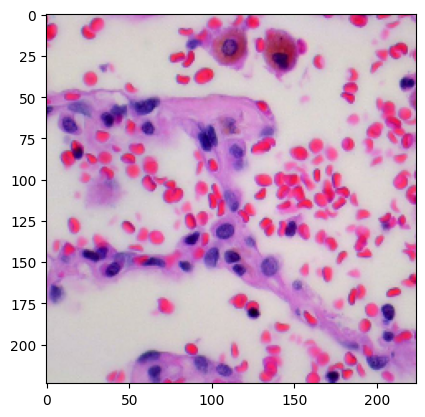

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


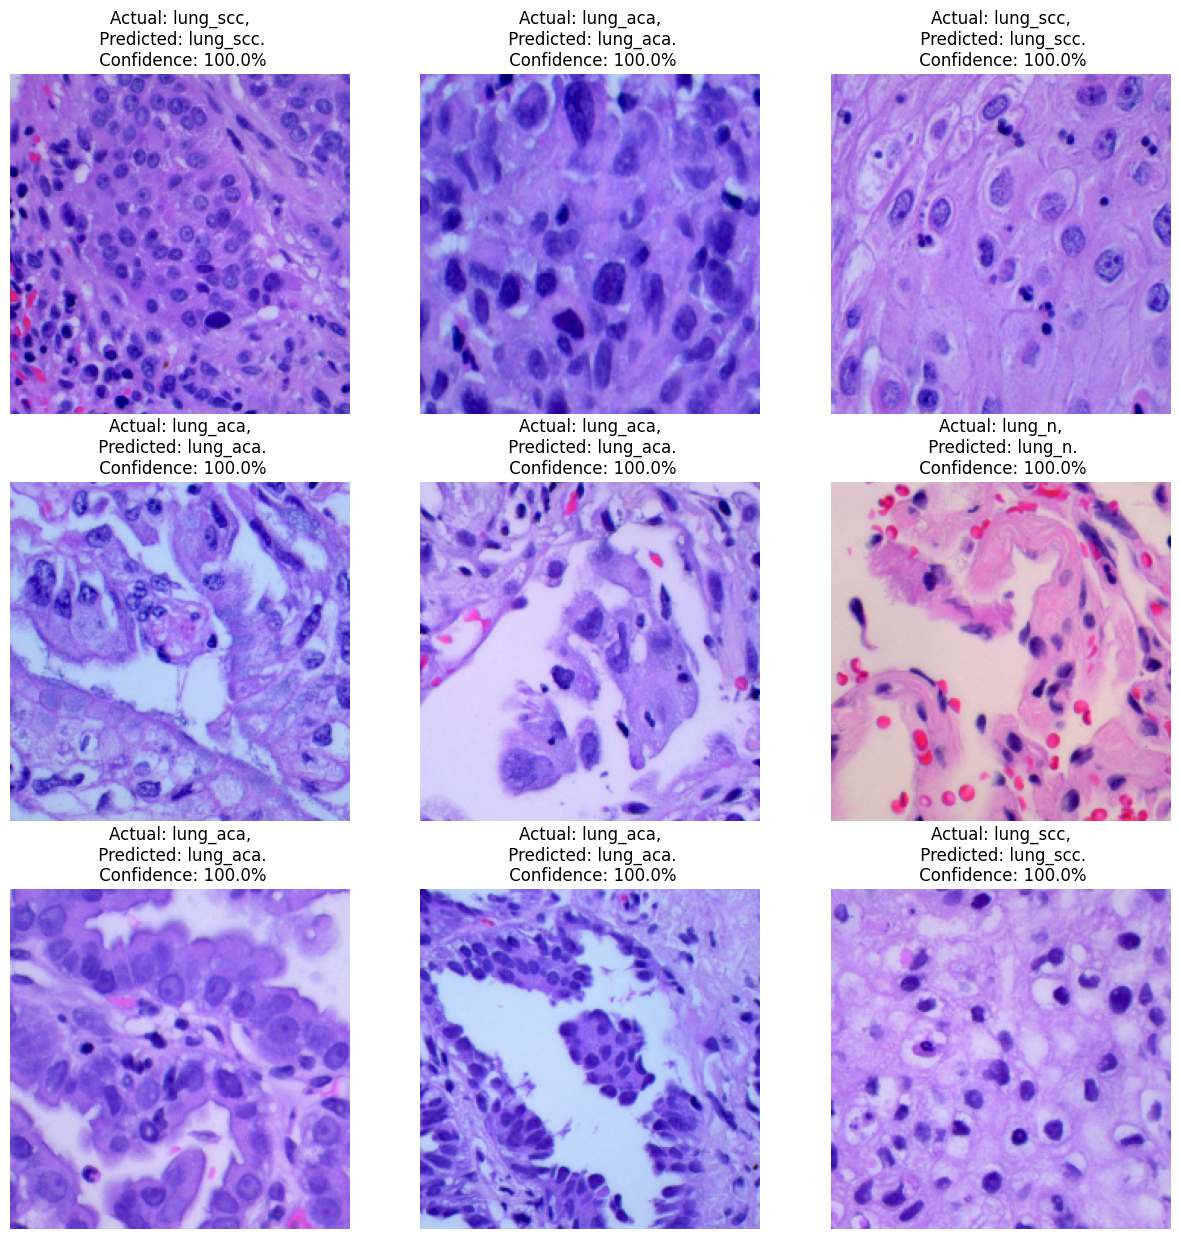

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [50]:
import os
model_version=1
model.save(f"/Desktop/DLLCP/{model_version}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/Desktop/DLLCP/1.